# Analyse sur les accidents en Ile-de-France

In [1]:
# for data
import numpy as np
import pandas as pd


#for plotting
import matplotlib.pyplot as plt
import descartes

## for geospatial
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import branca
from branca.element import Template, MacroElement

#for machine learning 
from sklearn import cluster
from sklearn.cluster import DBSCAN
import scipy
from sklearn.neighbors import NearestNeighbors

In [2]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')

In [3]:
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

## Les données sur les accidents de vélo

Le site d'où sont tirées les données : https://www.data.gouv.fr/fr/datasets/accidents-de-velo/

In [57]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')

C:\Users\Vinciane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
accident_velo_idf = accident_velo_idf[['identifiant accident','lat','lon','gravite accident', 'commune']]
#Quelques latitudes et longitudes aberrantes demeurent, alors on tente de les éliminer
accident_velo_idf
# Certaines coordonnées sont nulles 

identifiant accident       lat      lon        gravite accident commune
58             200500001606   0.00000  0.00000  2 - Blessé hospitalisé   78230
61             200500001930  49.06400  2.32800             0 - Indemne   95042
221            200500004591   0.00000  0.00000        1 - Blessé léger   75001
222            200500004597   0.00000  0.00000             0 - Indemne   75005
223            200500004600   0.00000  0.00000             0 - Indemne   75019
...                     ...       ...      ...                     ...     ...
65531          201800050291  48.86400  2.33134  2 - Blessé hospitalisé   75101
65532          201800050337  48.85854  2.34825        1 - Blessé léger   75101
65533          201800050355  48.86870  2.34133        1 - Blessé léger   75102
65534          201800050359  48.86470  2.34275        1 - Blessé léger   75101
65535          201800050370  48.86820  2.34361        1 - Blessé léger   75102

[17541 rows x 5 columns]

Pour les valeurs des longitudes et latitudes, j'ai cherché sur maps les latitudes et longitudes max d'ile de France.. 
On obtient

longitude min = 1,44 longitude max = 3,57
latitude min = 48.12 , latitude max= 49.2

In [59]:
#On transforme les coordonnées latitudes/longitudes en coordonnées lisibles par géopandas
gdf = gpd.GeoDataFrame(accident_velo_idf, geometry=gpd.points_from_xy(accident_velo_idf.lon, accident_velo_idf.lat))
#Elimination des valeurs manquantes et aberrantes (situées hors Ile-de-France)
gdf = gdf.cx[1.44:3.57,48.12:49.2]
gdf.head(5)  #On remarque qu'il nous reste 3462 accidents sur les 17541

identifiant accident     lat    lon        gravite accident commune  \
61            200500001930  49.064  2.328             0 - Indemne   95042   
1142          200500024289  48.697  1.771        1 - Blessé léger   78497   
1143          200500024300  48.850  1.890        1 - Blessé léger   78062   
1149          200500024520  48.575  2.166  2 - Blessé hospitalisé   91105   
1152          200500024639  48.730  2.100        1 - Blessé léger   78143   

                      geometry  
61    POINT (2.32800 49.06400)  
1142  POINT (1.77100 48.69700)  
1143  POINT (1.89000 48.85000)  
1149  POINT (2.16600 48.57500)  
1152  POINT (2.10000 48.73000)

### Travail sur la gravité des accidents avec une carte interactive

In [60]:
gdf2 = gdf.copy()
#On prépare les couleurs pour la carte folium
gdf2['col'] = gdf2['gravite accident'].apply(lambda x: "white" if x == '0 - Indemne' else x
                                            ).apply(lambda x: "orange" if x == "1 - Blessé léger" else x
                                            ).apply(lambda x: "red" if x == "2 - Blessé hospitalisé" else x
                                            ).apply (lambda x:"darkred" if x == "3 - Tué" else x)
#On prépare le texte pour les popups de la carte folium (qui ne reconnaissent pas les cédilles et les accents)
gdf2['gravite accident'] = gdf2['gravite accident'].apply(lambda x: "Blesse leger" if x == '1 - Blessé léger' else x
                                            ).apply(lambda x: "Blesse hospitalise" if x == "2 - Blessé hospitalisé" else x
                                            ).apply(lambda x: "Indemne" if x == "0 - Indemne" else x
                                            ).apply (lambda x:"Tue" if x == "3 - Tué" else x)

In [61]:
Paris = [48.85, 2.34]
map_accident = folium.Map(location=Paris,zoom_start=10)
marker_cluster = MarkerCluster().add_to(map_accident)
for i in range(gdf2.shape[0]):#nombre de lignes
    lat=float(gdf2.iloc[i,1])
    long=float(gdf2.iloc[i,2])
    grav=gdf2.iloc[i,3]
    col=gdf2.iloc[i,6]
    folium.Marker([lat, long], 
                  popup=folium.Popup(grav, parse_html=False, max_width=100),
                  icon=folium.Icon(icon="bicycle", icon_color='black', prefix="fa", color=col)
                 ).add_to(marker_cluster)

In [62]:
#On ajoute un titre à notre carte folium
loc = 'Accidents en Ile-de-France entre 2005 et 2018 en fonction de leur gravite'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
#On ajoute une légende présentant les différentes gravités des accidents
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="fr">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 1);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Gravite des accidents</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:white;opacity:1;'></span>Indemne</li>
    <li><span style='background:orange;opacity:1;'></span>Blesse leger</li>
    <li><span style='background:red;opacity:1;'></span>Blesse hospitalise</li>
    <li><span style='background:darkred;opacity:1;'></span>Tue</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
      .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 8px;
    width: 8px;
    border-radius: 4px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_accident.get_root().add_child(macro)
map_accident.get_root().html.add_child(folium.Element(title_html))
map_accident

### Trouver les lieux les plus accidentogènes avec la méthode du cluestering (DBSCAN)

In [63]:
X=gdf.loc[:,['lat','lon']]

On utilise DBSCAN, qui permet de créer un cluster avec : 
- epsilon : la distance entre deux accidents liés au même lieu accidentogène. Nous avons choisi comme distance 50m.
- min_samples : le nombre de point minimum pour créer un cluster. Nous avons choisi 3 points, car 2 accidents au même endroits ne pourraient être dus qu'à une coïncidence.

In [64]:
#centre cluster
def get_centroid(cluster): 
    cluster_ary = np.asarray(cluster) 
    centroid = cluster_ary.mean(axis=0) 
    return centroid 

In [65]:
#On choisit un epsilon : 
kms_per_radian = 6371 
epsilon = 0.05/kms_per_radian  #0.05km = 50m


#On applique DBSCAN a notre dataframe
gdf_acc = X.copy() 
dbsc = (DBSCAN(eps=epsilon, min_samples=3).fit(gdf_acc)) 

gdf_acc_labels = dbsc.labels_ 

num_clusters = len(set(dbsc.labels_))
num_clusters = num_clusters -1
print("Il y a", num_clusters, "clusters." )

Il y a 62 clusters.


In [66]:
dbsc_clusters = pd.Series([gdf_acc[gdf_acc_labels==n] for n in range(num_clusters)]) 
cluster_centroids = dbsc_clusters.map(get_centroid) 

#D'après la documentation, on sait que : 
#_labels donne l'étiquette de attribuée à chaque point
gdf['gdf_acc_labelse'] = gdf_acc_labels

#Les étiquettes qui valent -1 représentent les bruits (accidents qui ne sont pas dans des clusters).
gdf_filtered = gdf[gdf_acc_labels>-1]

#On prend en compte le message d'erreur et on l'ignore pour le notebook final
#import numpy as np
#np.seterr(divide='ignore', invalid='ignore')

In [67]:
cent_lat, cent_lon = zip(*cluster_centroids)
centroids_df = pd.DataFrame({'lon':cent_lon, 'lat':cent_lat}) 
#Liste des lieux particulièrement accidentogènes en Ile-de-France

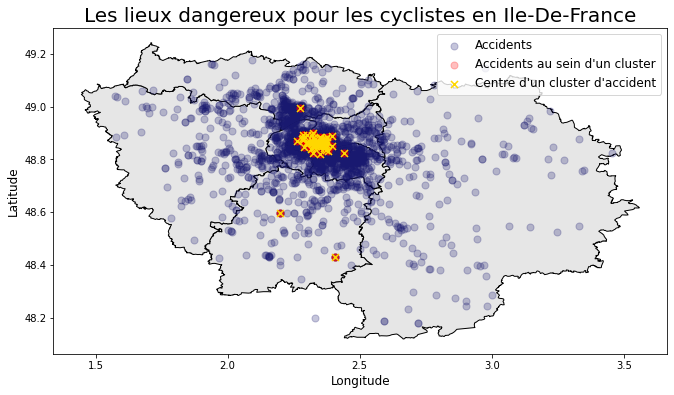

In [68]:
#Carte présentant les lieux (en jaune) où il y a eu plus de 3 accidents entre 2005 et 2018 dans un rayon de 50m

fig, ax = plt.subplots(figsize=[11, 8]) 
dpt.plot(ax=ax, color='0.9', edgecolor='black')
accident_scatter = ax.scatter(gdf['lon'], gdf['lat'], c ='midnightblue',alpha=0.25, s=50) 
filtres_scatter = ax.scatter(gdf_filtered['lon'], gdf_filtered['lat'],  c= 'red', alpha =0.25, s=50) 
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'],marker='x', linewidths=2, c='gold', s=50) 

ax.set_title("Les lieux dangereux pour les cyclistes en Ile-De-France", fontsize =20) 
ax.set_xlabel('Longitude', fontsize=12) 
ax.set_ylabel('Latitude', fontsize =12) 

ax.legend([accident_scatter,filtres_scatter, centroid_scatter], ['Accidents', "Accidents au sein d'un cluster", "Centre d'un cluster d'accident"], loc='upper right', fontsize = 12) 

plt.show()
